<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

-----
-----

**Summary этого ноутбука:** все ячейки работают, графики в целом адекватные. GAN неожиданно лучше диффузии, градиентный бустинг ожидаемо лучше линейной регрессии. ROC AUC для GAN равен 0.81, ROC AUC для диффузии равен 0.99.

Эксперименты с архитектурами иногда улучшали качество, но незначительно.

-----
-----

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
!pip install diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00


In [ ]:
from diffusers import DDPMScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

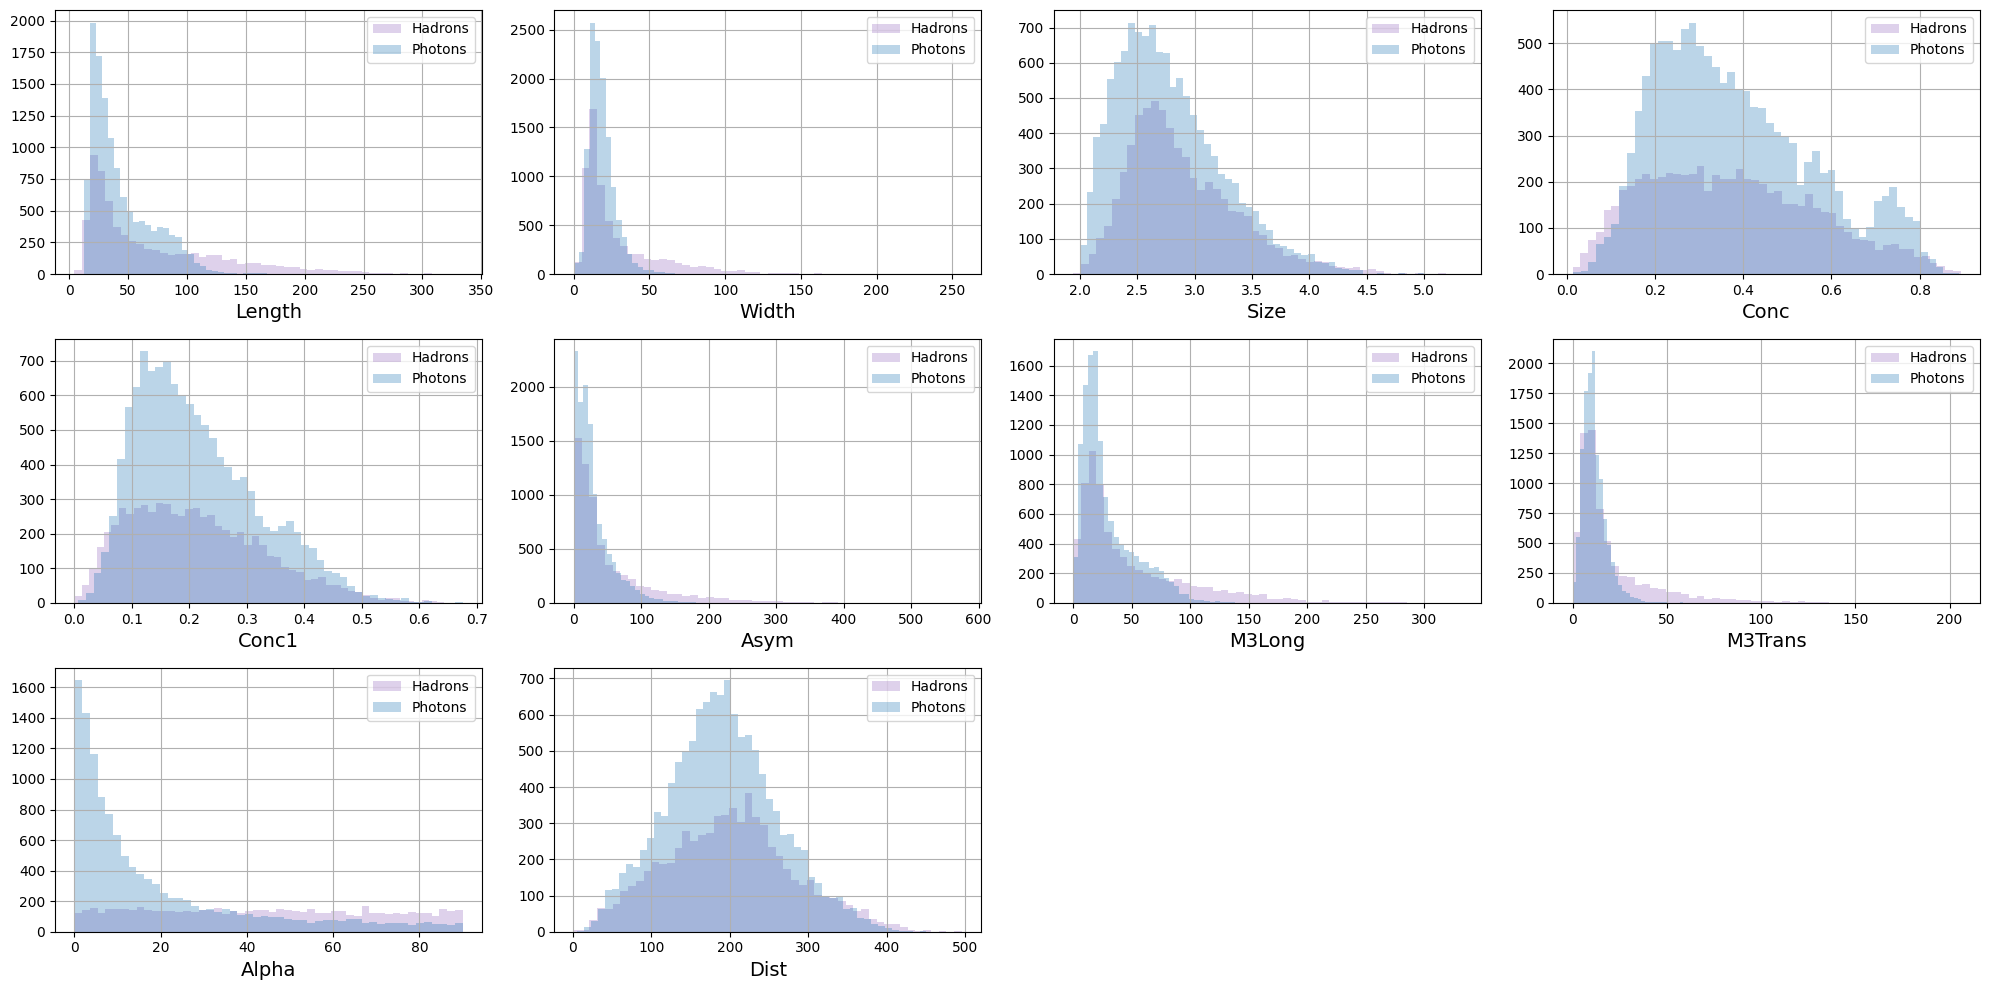

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

-----
-----

[0.0, 1.0] = ["Hadrons", "Photons"]

-----
-----

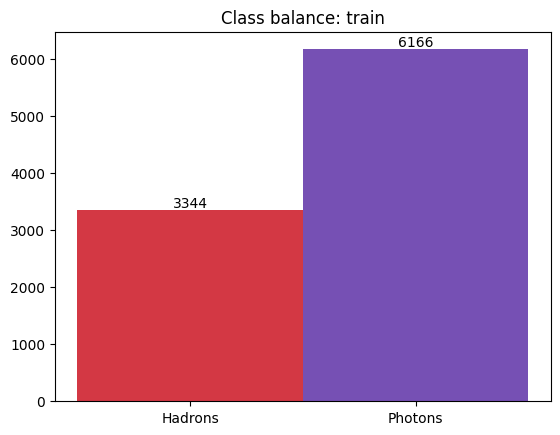

In [ ]:
fig, ax  = plt.subplots()
ax.bar([1, 2], [len(y_train[y_train == 0]), len(y_train[y_train == 1])], width=1,
       tick_label=["Hadrons", "Photons"], align='center', color=["#D33844", "#7650B4"])
ax.set_title("Class balance: train")
rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )

plt.show()

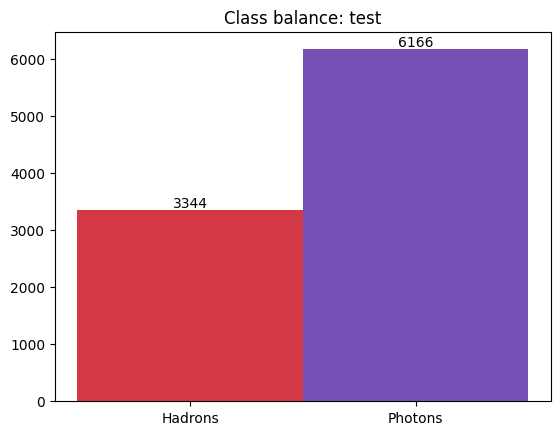

In [ ]:
fig, ax  = plt.subplots()
ax.bar([1, 2], [len(y_test[y_test == 0]), len(y_test[y_test == 1])], width=1,
       tick_label=["Hadrons", "Photons"], align='center', color=["#D33844", "#7650B4"])
ax.set_title("Class balance: test")
rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )

plt.show()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
qt = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

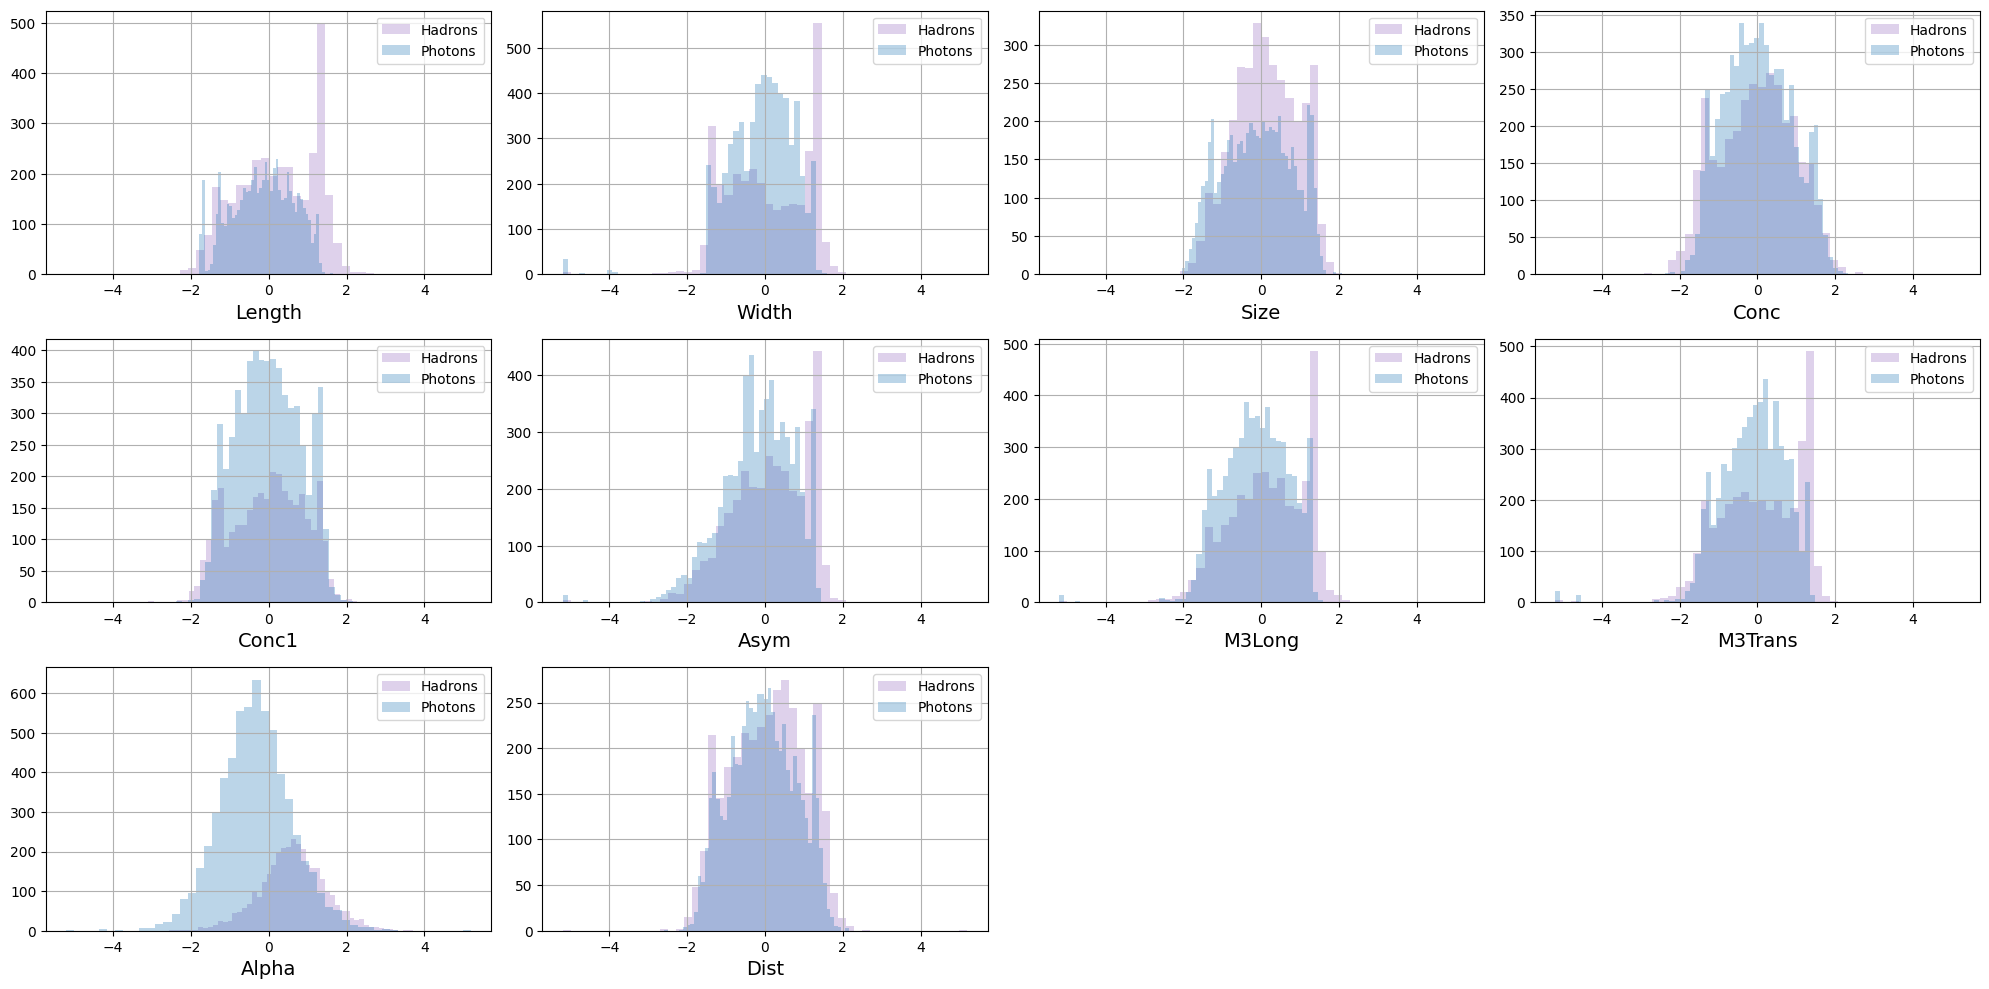

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

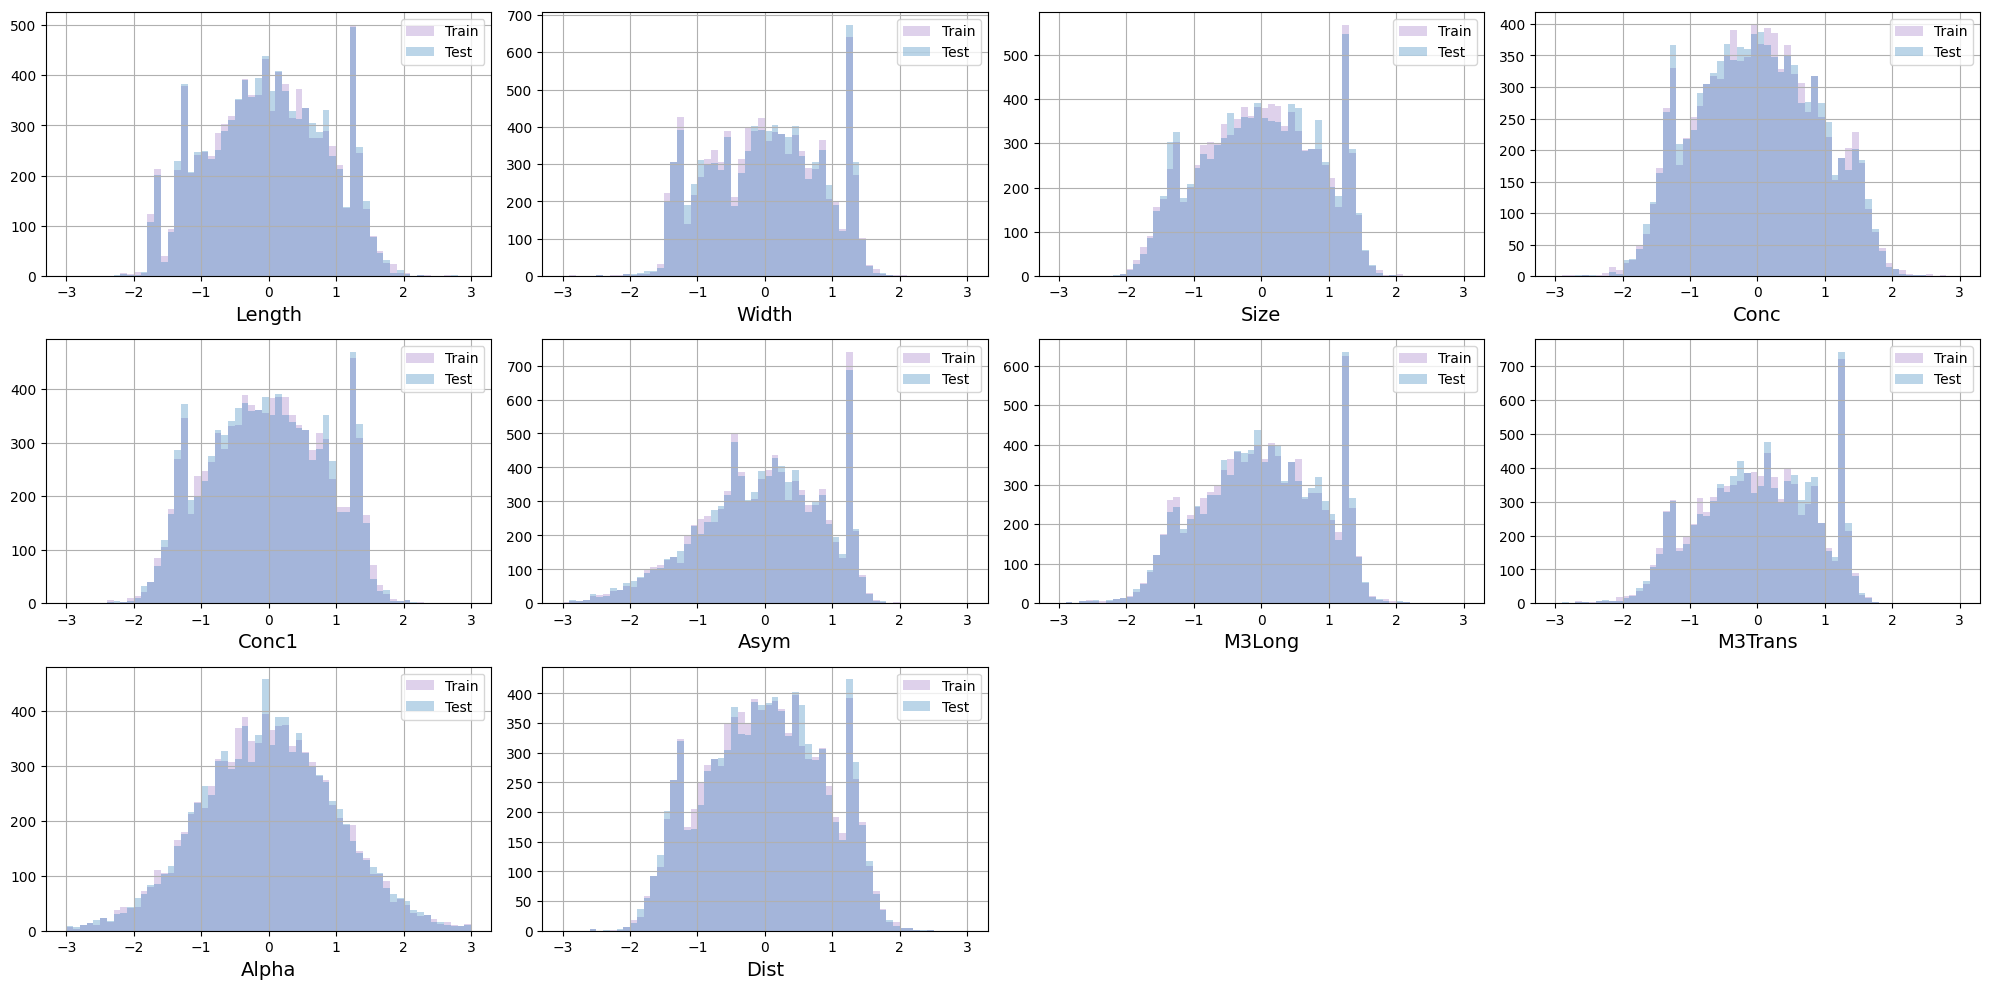

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )


    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1).to(DEVICE)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    new_objects = torch.normal(0, 1, (len(y), latent_dim))
    y = torch.tensor(y, dtype=torch.float32)

    device = next(generator.parameters()).device
    new_objects = new_objects.to(device)
    y = y.to(device)

    with torch.no_grad():
        X_fake = generator(new_objects, y)

    X_fake = X_fake.cpu().numpy()

    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

-----
-----

Нам объяснили на семинаре, что в целом необходимость функции активации в конце работы модели проверяется эмпирически. В данном случае сигмоида выглядит логичным решением, ведь у нас всего два класса. Однако ее добавление не повлияло на результаты, следовательно, она необязательна.

-----
-----

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.n_inputs = n_inputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
#            nn.Sigmoid(),
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1).to(DEVICE)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

-----
-----

Желательно низкое значение accuracy, ведь в таком случае оно будет говорить о том, что отличить сгенерированные изобржения от реальных сложно, а значит, мы хорошо выполнили поставленную задачу.

-----
-----

In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    X_real = X_real.detach().cpu().numpy()
    y_real = y_real.detach().cpu().numpy()
    X_fake = X_fake.detach().cpu().numpy()
    y_fake = y_fake.detach().cpu().numpy()

    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.25, stratify=y_real)
    X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(X_fake, y_fake, test_size=0.25, stratify=y_fake)

    X_train_stacked = np.vstack([X_train_real, X_train_fake])
    y_train_stacked = np.hstack([y_train_real, y_train_fake])
    X_test_stacked = np.vstack([X_test_real, X_test_fake])
    y_test_stacked = np.hstack([y_test_real, y_test_fake])

    model1 = LogisticRegression()
    model1.fit(X_train_stacked, y_train_stacked)

    model2 = GradientBoostingClassifier()
    model2.fit(X_train_stacked, y_train_stacked)
    pred_2 = model2.predict(X_test_stacked)

    lin_reg_score = model1.score(X_test_stacked, y_test_stacked)
    boosting_score = accuracy_score(y_test_stacked, pred_2)

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

-----
-----

В 9-м задании представлено полное описание экспериментов.

-----
-----

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                X_fake = self.generator(Z_noise, cond_batch).to(DEVICE)

                for i in range(self.n_critic):
                    self.opt_disc.zero_grad()
                    discriminator_loss = -torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(X_fake, cond_batch))
                    discriminator_loss.backward(retain_graph=True)
                    for p in self.discriminator.parameters():
                      p.data.clamp_(-0.01, 0.01)
                    self.opt_disc.step()

                self.opt_gen.zero_grad()
                generator_loss = -torch.mean(self.discriminator(X_fake, cond_batch))
                generator_loss.backward()
                self.opt_gen.step()

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond).to(DEVICE)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            n = 1000
            X_real_sample = X_real[:n].to(DEVICE)
            Z_noise = torch.randn(n, self.latent_dim).to(DEVICE)
            X_fake_sample = self.generator(Z_noise, y_cond[:n]).to(DEVICE)
            other_agent_score(X_real_sample, torch.ones(n), X_fake_sample, torch.zeros(n))

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.614
Boosting score: 0.738
Linear regression score: 0.55
Boosting score: 0.724
Linear regression score: 0.548
Boosting score: 0.73
Linear regression score: 0.514
Boosting score: 0.714
Linear regression score: 0.664
Boosting score: 0.706
Linear regression score: 0.532
Boosting score: 0.688
Linear regression score: 0.548
Boosting score: 0.7
Linear regression score: 0.592
Boosting score: 0.708
Linear regression score: 0.466
Boosting score: 0.66
Linear regression score: 0.52
Boosting score: 0.692
Linear regression score: 0.586
Boosting score: 0.69
Linear regression score: 0.508
Boosting score: 0.67
Linear regression score: 0.48
Boosting score: 0.66
Linear regression score: 0.512
Boosting score: 0.656
Linear regression score: 0.518
Boosting score: 0.636
Linear regression score: 0.51
Boosting score: 0.664
Linear regression score: 0.576
Boosting score: 0.69
Linear regression score: 0.558
Boosting score: 0.684
Linear regression score: 0.526
Boosting score: 0.668
Linea

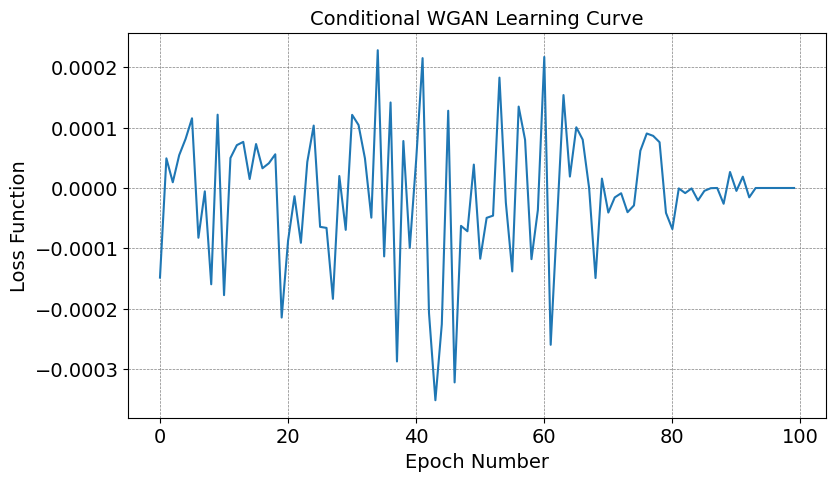

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
X_train_original = qt.inverse_transform(X_train)
X_test_original = qt.inverse_transform(X_test)

In [ ]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train_original = qt.inverse_transform(X_fake_train)

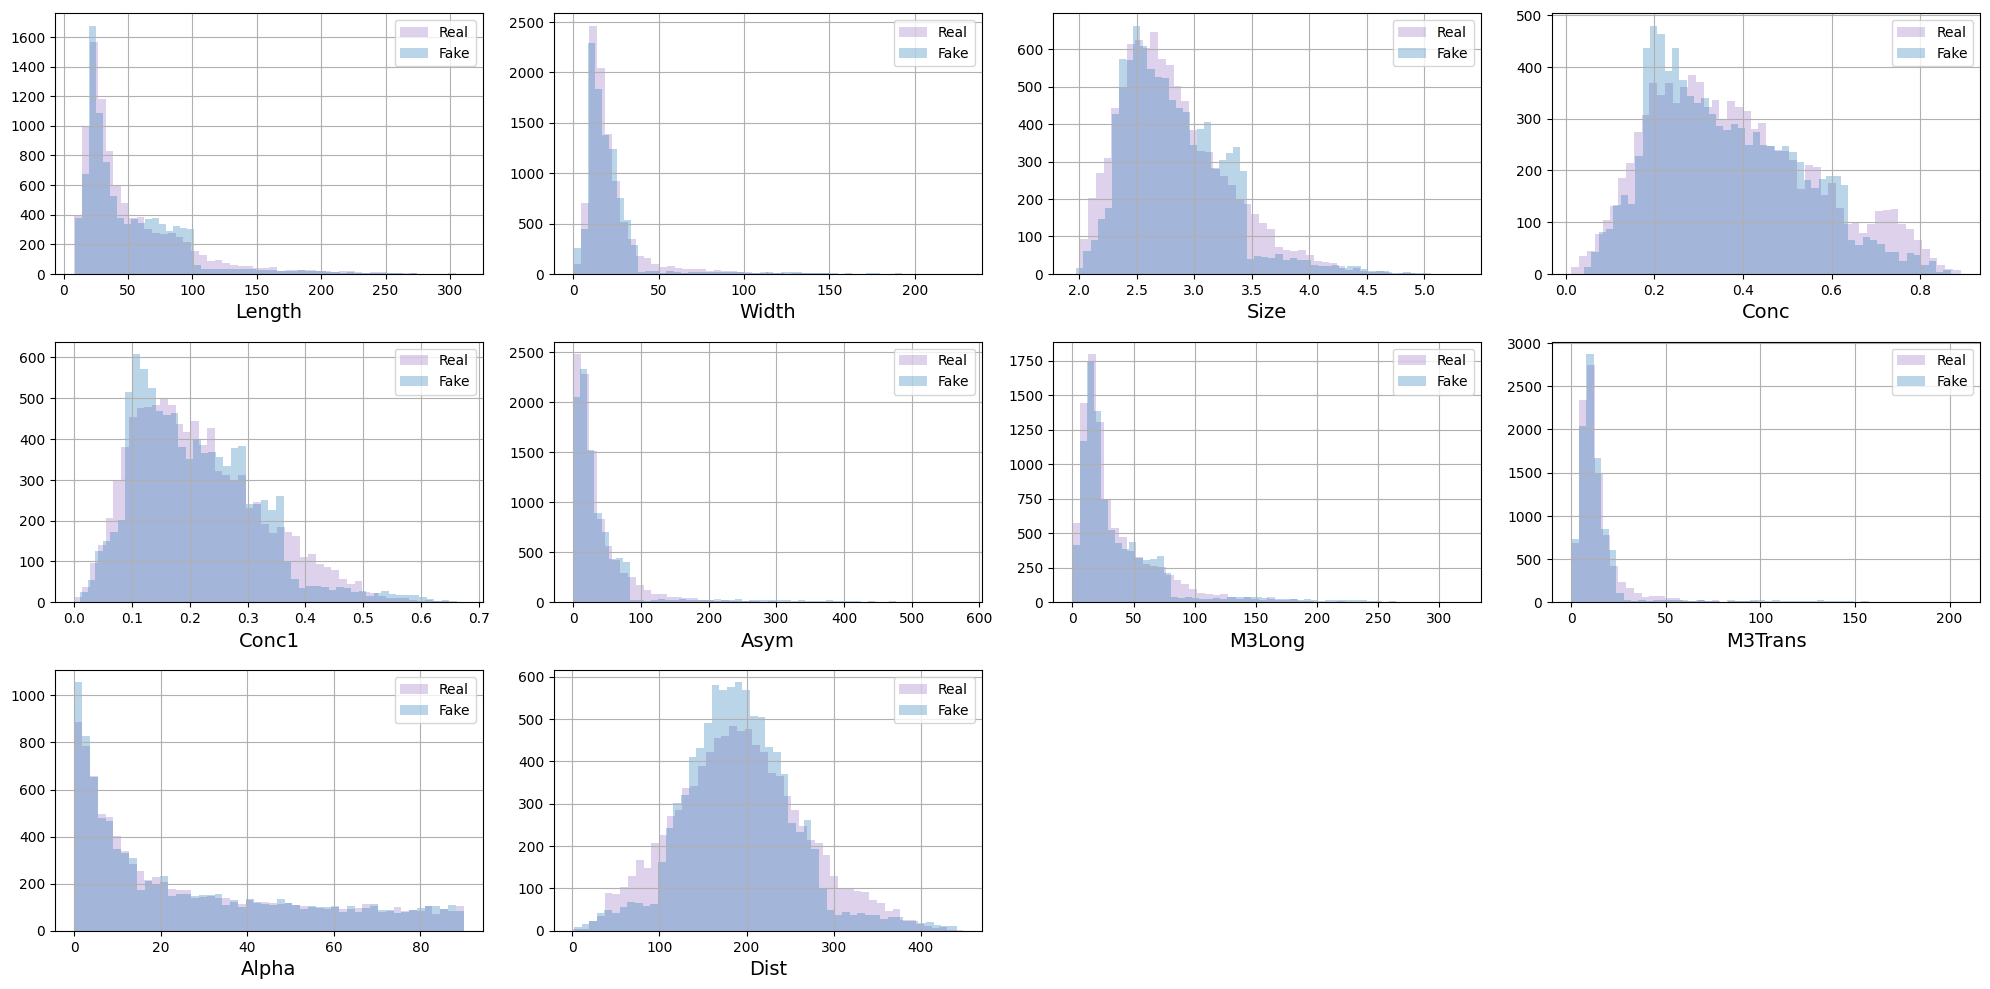

In [ ]:
plot_hists(X_train_original, X_fake_train_original, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test_original = qt.inverse_transform(X_fake_test)

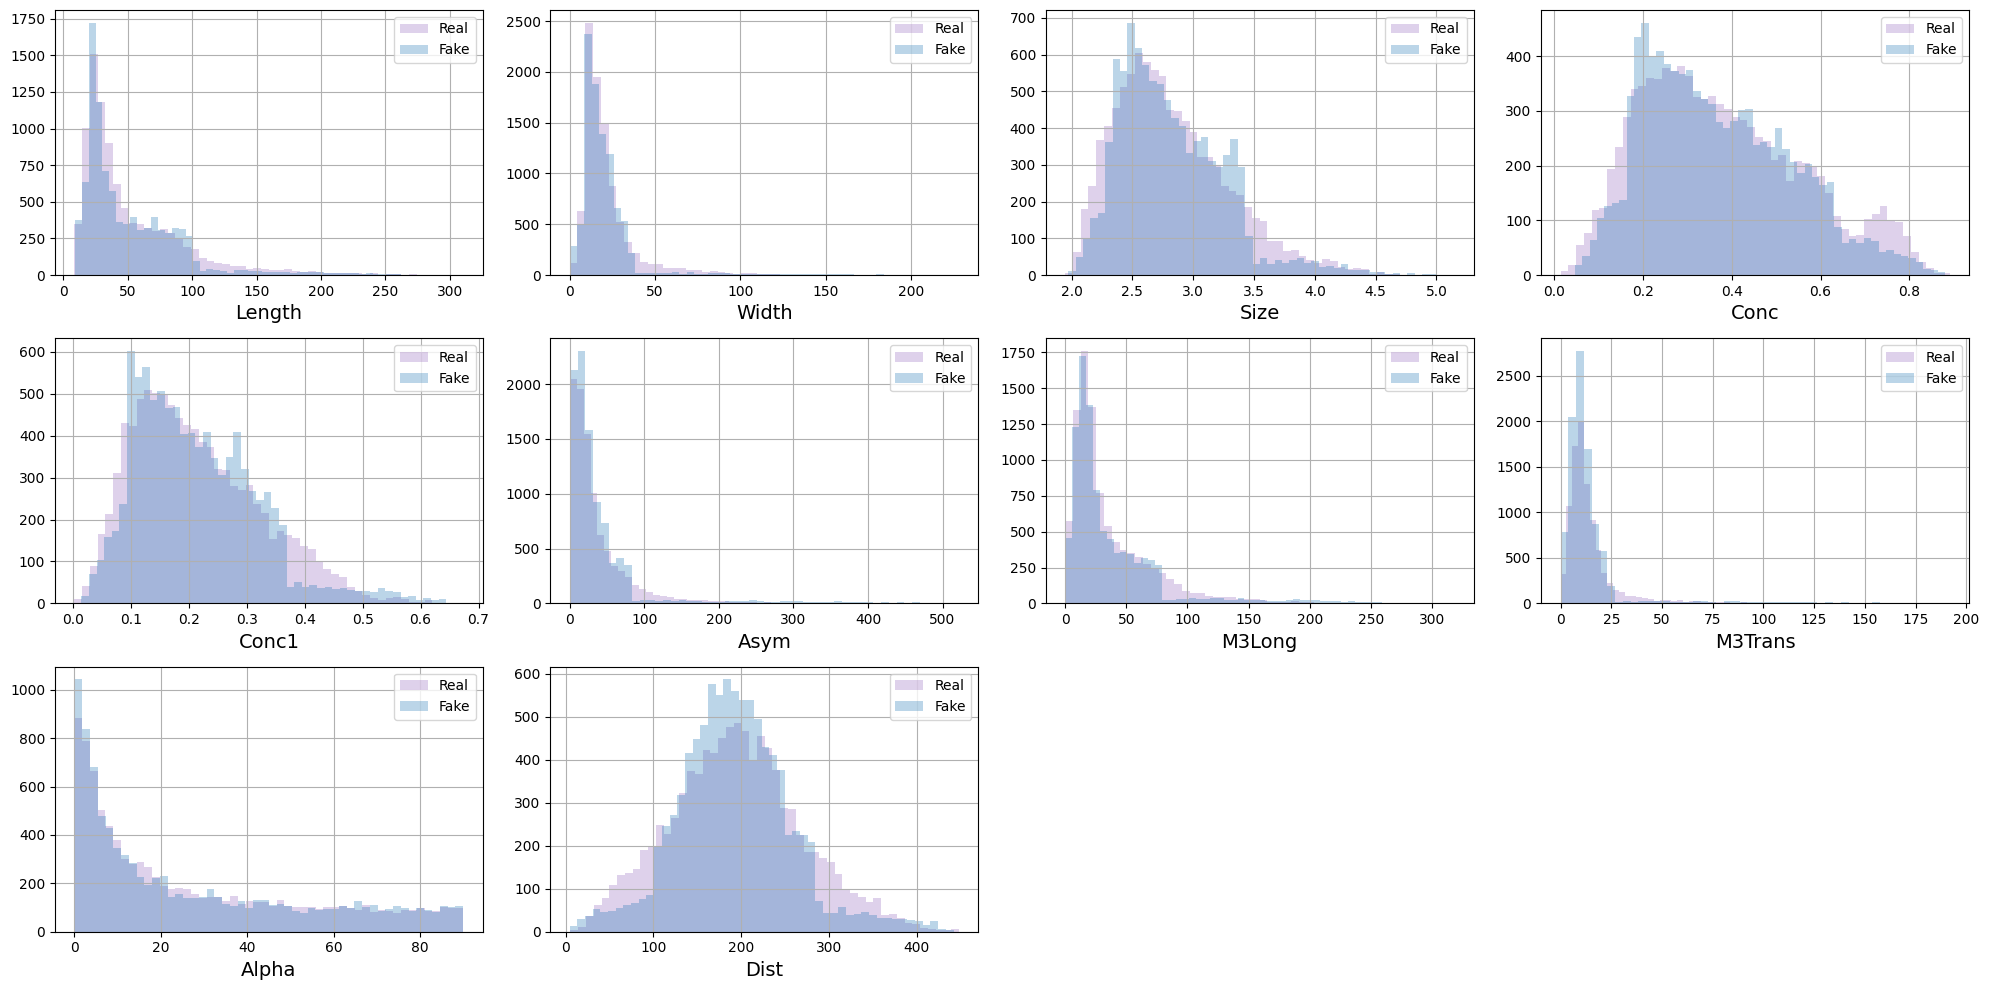

In [ ]:
plot_hists(X_test_original, X_fake_test_original, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8107813237712033


In [ ]:
# чтобы посчитать accuracy_score
yy_test_proba_round = np.round(yy_test_proba)

In [ ]:
acc = accuracy_score(yy_test, yy_test_proba_round)
print("Accuracy = ", acc)

Accuracy =  0.7177707676130389


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


-----
-----

Несколько экпериментов позволили сделать выводы:

1) Добавление сигмоиды в конце дискриминатора в данной задаче действительно ничего не принесло

2) Значения функции потерь зависят от того, как сильно мы ограничиваем веса с помощью p.data.clamp_()

3) Иногда значения функции потерь были отрицательными, хотя нам объяснили, что в данной задаче это нормально:

"В случае WGAN'а в качестве лосса выступает выход критика (дискриминатора) на тех или иных данных. Данный выход непрерывный, ничем не ограничен, хотя и мы ожидаем, что он будет являться оценкой расстояния Вассерштейна. Поэтому данная чиселка может быть отрицательной."

Говоря о ROC AUC, нас бы удовлетворило низкое значение, поскольку оно свидетельствовало бы о том, что отличить сгенерированные изображения от реальных сложно. Однако в нашем случае значение достаточно высокое, следовательно, модель справилась не очень хорошо.

При этом получилось так, что accuracy score у линейной регрессии и градиентного бустинга высокий, несмотря на то, что этот показатель снижался. Это означает, что сгенерированные изображения неправдоподобны и их действительно легко отличить от реальных.

Также стоит отметить закономерное превосходство градиентного бустинга над линейной регрессией: он сложнее устроен (в нем композиция моделей) и в целом больше подходит для данной задачи, чем линейная регрессия.

-----
-----

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(amount.shape[0], 1)
    x = x * (1 - amount) + noise * amount
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

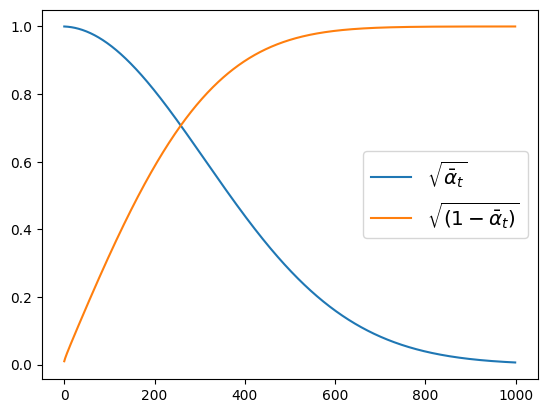

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

-----
-----

В классе DiffusionFitter так же, как в GAN, будет присутствовать other_agent_score, при этом после экспериментов будут вычислены ROC AUC и accuracy.

-----
-----

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )


    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

In [ ]:
# этот класс использовался для эксперимента,
# но нельзя сказать, что результаты сильно изменились

class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, n_outputs),
        )


    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

In [ ]:
# этот класс тоже использовался для эксперимента,
# но нельзя сказать, что результаты сильно изменились

class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 264),
            nn.BatchNorm1d(264),
            nn.LeakyReLU(),
            nn.Linear(264, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, n_outputs),
        )


    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    x = torch.randn((y.shape[0], latent_dim), dtype=torch.float).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)

    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
        with torch.no_grad():
            residual = model(x, y)
        X_fake = scheduler.step(residual, t, x).prev_sample

    return X_fake.detach().cpu().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        loss_fn = nn.MSELoss()

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                noise = torch.randn(real_batch.shape[0]).to(DEVICE)
                noisy_x = corrupt(real_batch, noise).to(DEVICE)

                pred = self.model(noisy_x, cond_batch)
                loss = loss_fn(pred, real_batch)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            n = 1000
            X_real_sample = X_real[:n]
            amount = torch.randn(X_real_sample.shape[0]).to(DEVICE)
            Z_noise = corrupt(X_real_sample, amount)
            X_fake_sample = self.model(Z_noise, y_cond[:n])
            other_agent_score(X_real_sample, torch.ones(n), X_fake_sample, torch.zeros(n))

        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.518
Boosting score: 0.81
Linear regression score: 0.486
Boosting score: 0.768
Linear regression score: 0.488
Boosting score: 0.728
Linear regression score: 0.502
Boosting score: 0.75
Linear regression score: 0.49
Boosting score: 0.73
Linear regression score: 0.51
Boosting score: 0.72
Linear regression score: 0.482
Boosting score: 0.706
Linear regression score: 0.52
Boosting score: 0.672
Linear regression score: 0.494
Boosting score: 0.69
Linear regression score: 0.49
Boosting score: 0.72
Linear regression score: 0.528
Boosting score: 0.724
Linear regression score: 0.524
Boosting score: 0.66
Linear regression score: 0.542
Boosting score: 0.68
Linear regression score: 0.562
Boosting score: 0.704
Linear regression score: 0.482
Boosting score: 0.614
Linear regression score: 0.564
Boosting score: 0.676
Linear regression score: 0.554
Boosting score: 0.666
Linear regression score: 0.48
Boosting score: 0.674
Linear regression score: 0.49
Boosting score: 0.664
Linear 

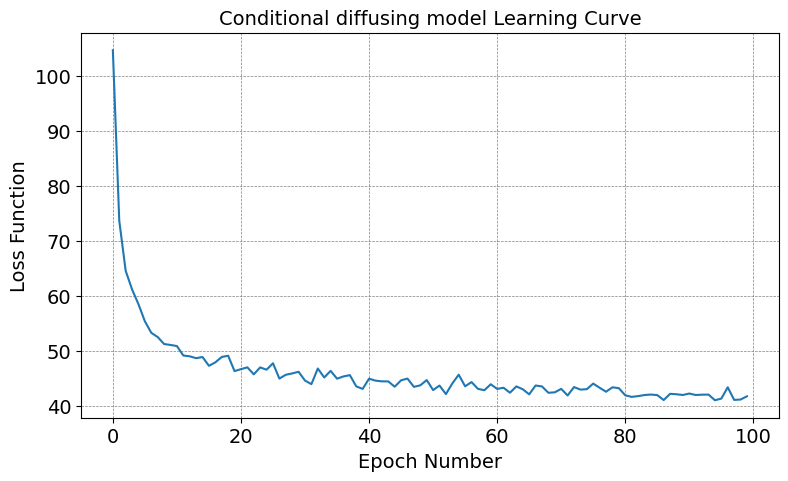

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

-----
-----

Подобно обучению GAN, функция потерь постепенно снижалась, линейная регрессия и градиентный бустинг с первых эпох стали ошибаться, хотя потом основные метрики изменялись в определенном диапазоне. При этом градиентный бустинг снова оказался лучше линейной регрессии.

Эксперименты с архитектурой модели улучшали результат, но незначительно.

-----
-----

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [ ]:
X_train_original = qt.inverse_transform(X_train)
X_test_original = qt.inverse_transform(X_test)

In [ ]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, scheduler=DDPMScheduler(num_train_timesteps=1000))
X_fake_train_original = qt.inverse_transform(X_fake_train)

0it [00:00, ?it/s]

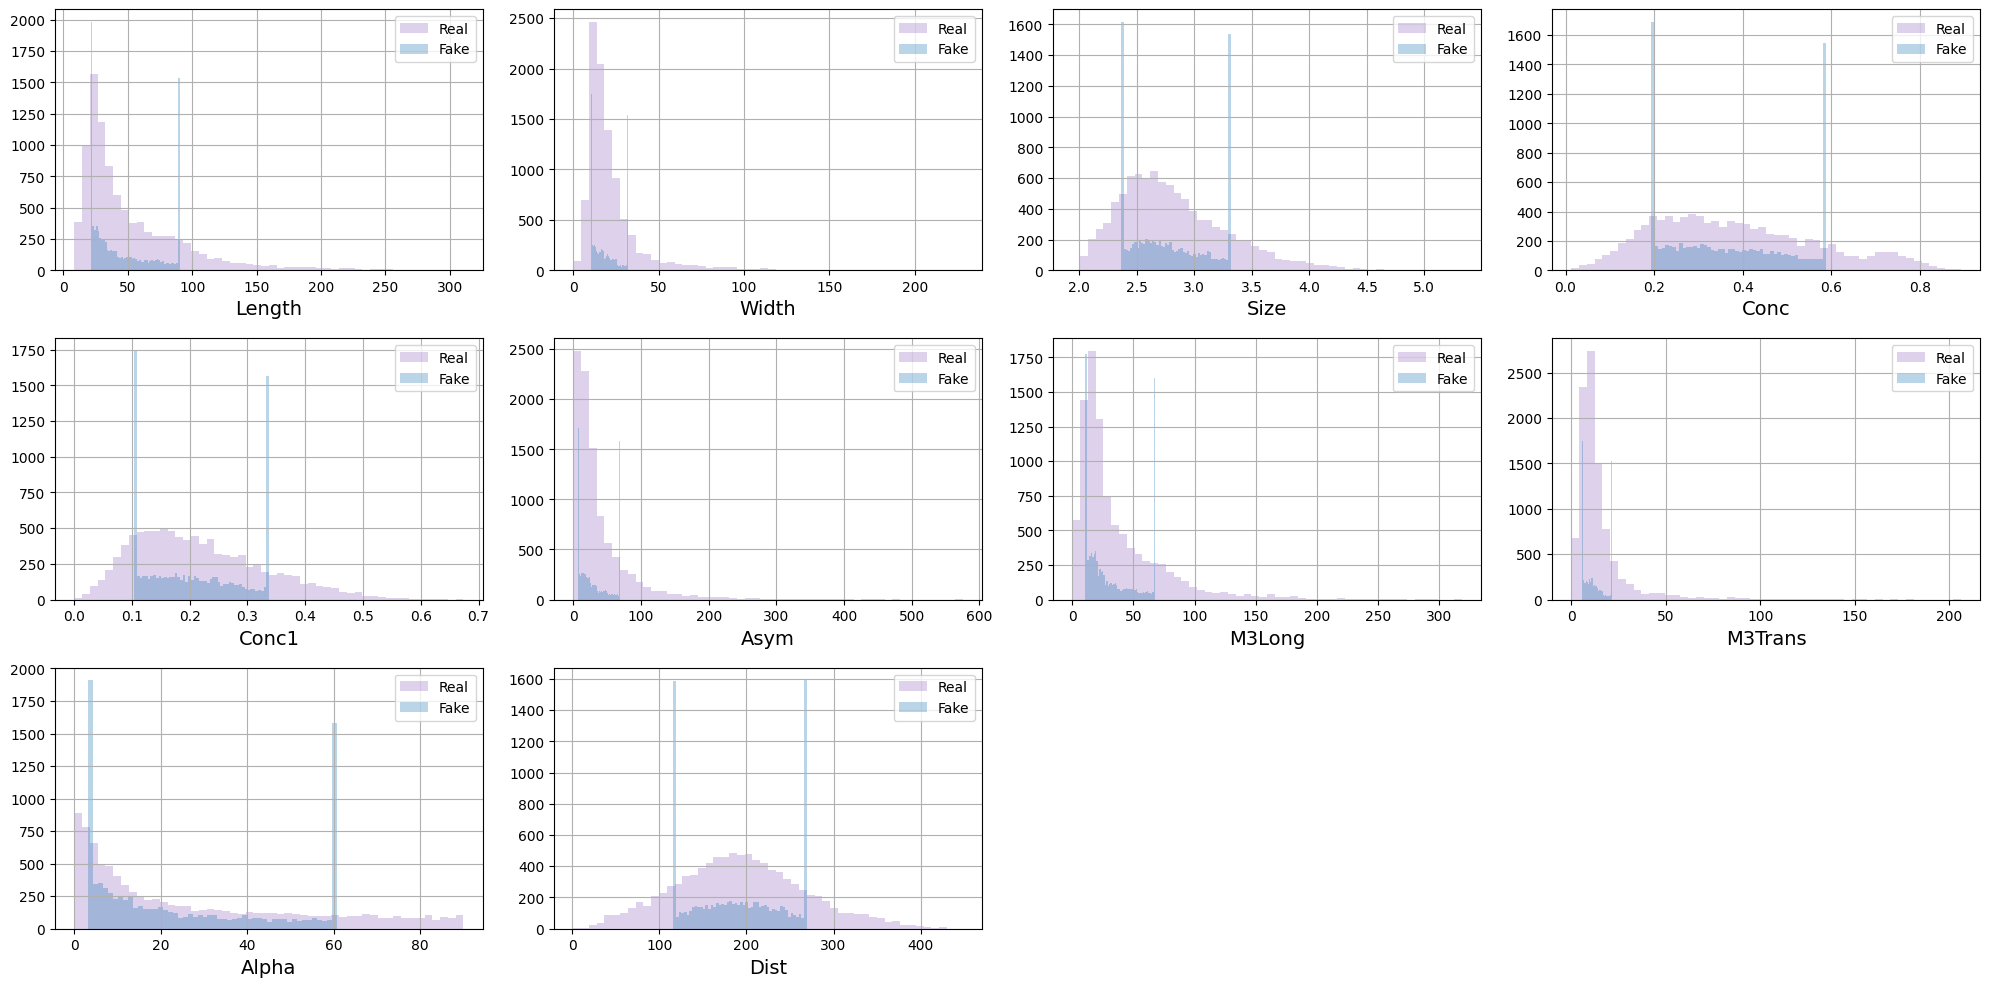

In [ ]:
plot_hists(X_train_original, X_fake_train_original, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, scheduler=DDPMScheduler(num_train_timesteps=1000))
X_fake_test_original = qt.inverse_transform(X_fake_test)

0it [00:00, ?it/s]

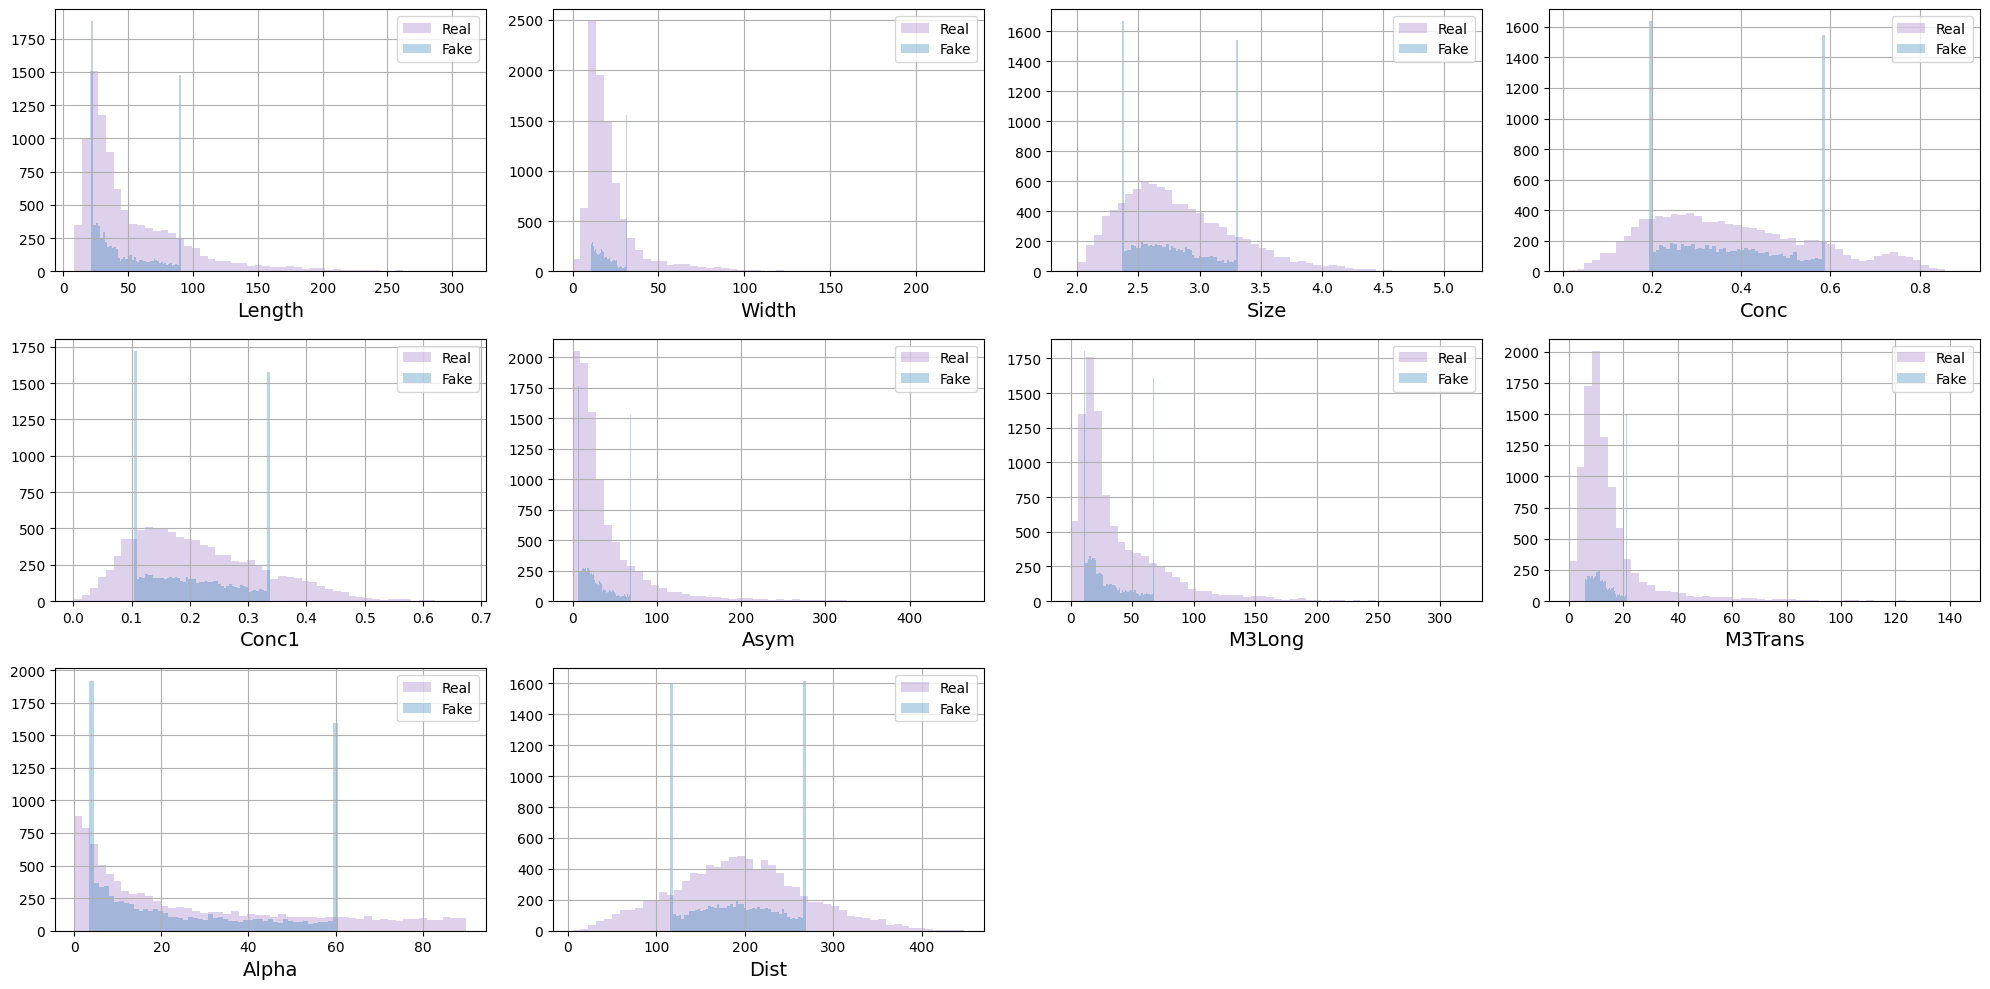

In [ ]:
plot_hists(X_test_original, X_fake_test_original, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
# чтобы посчитать accuracy_score
yy_test_proba_round = np.round(yy_test_proba)

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_proba_round)
print("ROC AUC = ", auc)
print("Accuracy = ", acc)

ROC AUC =  0.9988164707911645
Accuracy =  0.9865930599369085


-----
-----

ROC AUC и accuracy снова очень высокие. Более того, они выше, чем в случае с GAN. Следовательно, отличить сгенерированные изображения от реальных легко, поэтому модель нужно улучшить.

-----
-----

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

In [ ]:
# \ (^_^) /  Всё отлично!